In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.16.1


In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
df =  pd.read_csv('Brent_Oil_Futures_Historical_Data.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/27/1988,15.10,15.10,15.10,15.10,0.05K,-3.51%
1,06/28/1988,15.27,15.34,15.36,15.27,0.16K,1.13%
2,06/29/1988,15.47,15.47,15.47,15.47,NaN,1.31%
3,06/30/1988,14.85,14.80,14.90,14.80,0.42K,-4.01%
4,07/01/1988,14.60,14.60,14.60,14.60,0.05K,-1.68%


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9129 non-null   object 
 1   Price     9129 non-null   float64
 2   Open      9129 non-null   float64
 3   High      9129 non-null   float64
 4   Low       9129 non-null   float64
 5   Vol.      9123 non-null   object 
 6   Change %  9129 non-null   object 
dtypes: float64(4), object(3)
memory usage: 499.4+ KB


In [6]:
unit_mapping = {'K': 1000}

def convert_to_numeric(value):
    if isinstance(value, str) and value[-1] in unit_mapping:
        unit = value[-1]
        number = float(value[:-1])
        return number * unit_mapping[unit]
    elif isinstance(value, str):
        return float(value)
    else:
        return value

def remove_percentage(value):
    if isinstance(value, str) and value[-1] == '%':
        return float(value[:-1])
    else:
        return value

df['Change %'] = df['Change %'].apply(remove_percentage)
df['Vol.'] = df['Vol.'].apply(convert_to_numeric)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/27/1988,15.10,15.10,15.10,15.10,50.0,-3.51
1,06/28/1988,15.27,15.34,15.36,15.27,160.0,1.13
2,06/29/1988,15.47,15.47,15.47,15.47,NaN,1.31
3,06/30/1988,14.85,14.80,14.90,14.80,420.0,-4.01
4,07/01/1988,14.60,14.60,14.60,14.60,50.0,-1.68


In [7]:
imputer = SimpleImputer(strategy='mean')
df['Vol.'] = imputer.fit_transform(df[['Vol.']])

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9129 non-null   object 
 1   Price     9129 non-null   float64
 2   Open      9129 non-null   float64
 3   High      9129 non-null   float64
 4   Low       9129 non-null   float64
 5   Vol.      9129 non-null   float64
 6   Change %  9129 non-null   float64
dtypes: float64(6), object(1)
memory usage: 499.4+ KB


In [10]:
train_size = int(len(df) * 0.8)
training_data = df[:train_size]
testing_data = df[train_size:]

In [11]:
x_train_cols = training_data.iloc[:, 1:7].values  
y_train_col = training_data.iloc[:, 1].values

In [12]:
sc = MinMaxScaler(feature_range=(0,1))
x_train_scaled = sc.fit_transform(x_train_cols)

In [13]:
with open('./models/LSTM.pkl', 'wb') as f:
    pickle.dump(sc, f)

In [14]:
x_train_scaled

array([[4.00175901e-02, 3.95314788e-02, 3.74409306e-02, 4.12026726e-02,
        8.62440707e-05, 6.40311348e-01],
       [4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
        3.23415265e-04, 7.35354363e-01],
       [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
        2.40647380e-01, 7.39041376e-01],
       ...,
       [3.37950748e-01, 3.37628111e-01, 3.36604871e-01, 3.41573868e-01,
        5.87559293e-01, 7.04219582e-01],
       [3.37217825e-01, 3.37042460e-01, 3.36532170e-01, 3.38381589e-01,
        6.70181113e-01, 7.08521098e-01],
       [3.38390501e-01, 3.36969253e-01, 3.33914940e-01, 3.38158872e-01,
        5.83182406e-01, 7.18148300e-01]])

In [15]:
x_train = []
y_train = []

for i in range(60, len(training_data) - 1):
    x_train.append(x_train_scaled[i-60:i+1, :]) 
    y_train.append(y_train_col[i+1])

x_train, y_train = np.array(x_train), np.array(y_train)

In [16]:
x_train

array([[[4.00175901e-02, 3.95314788e-02, 3.74409306e-02, 4.12026726e-02,
         8.62440707e-05, 6.40311348e-01],
        [4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
         3.23415265e-04, 7.35354363e-01],
        [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
         2.40647380e-01, 7.39041376e-01],
        ...,
        [3.00498388e-02, 2.92825769e-02, 2.84987277e-02, 3.07349666e-02,
         3.49288486e-03, 6.81278165e-01],
        [2.79976546e-02, 2.70131772e-02, 2.54452926e-02, 2.73199703e-02,
         4.26908150e-03, 6.70421958e-01],
        [2.90237467e-02, 2.79648609e-02, 2.72628135e-02, 2.94729027e-02,
         1.18585597e-03, 7.33510856e-01]],

       [[4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
         3.23415265e-04, 7.35354363e-01],
        [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
         2.40647380e-01, 7.39041376e-01],
        [3.81852829e-02, 3.73352855e-02, 3.59869138e-02, 3.897550

In [17]:
y_train

array([13.52, 13.58, 13.52, ..., 55.75, 55.65, 55.81])

In [18]:
x_train.shape

(7242, 61, 6)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(61, 6)),
    tf.keras.layers.LSTM(units=60, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=60, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=120, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 61, 60)         │        16,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 61, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 61, 60)         │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 61, 80)         │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 61, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,841 (729.85 KB)

 Trainable params: 186,841 (729.85 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint = ModelCheckpoint('./models/LSTM.keras', monitor='loss', verbose=1, save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logs'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [21]:
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

In [22]:
model.fit(x_train, y_train, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150


113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 685212639952896.0000
Epoch 1: loss improved from inf to 568466973130752.00000, saving model to ./models/LSTM.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 683182328381440.0000 - learning_rate: 0.0010
Epoch 2/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2032.6453
Epoch 2: loss improved from 568466973130752.00000 to 2016.82141, saving model to ./models/LSTM.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 2032.3701 - learning_rate: 0.0010
Epoch 3/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1905.9381
Epoch 3: loss improved from 2016.82141 to 1903.23621, saving model to ./models/LSTM.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 1905.8911 - learning_rate: 0.0010
Epoch 4/150
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1911.1245
Epoch 4: loss improved from 1903.23621 to 1848.53796, saving model to ./models/LSTM.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1910.5802 - learning_rate

In [23]:
real_price = testing_data.iloc[:, 1].values

In [24]:
real_price.shape

(1826,)

In [25]:
predictions = []
for i in range(len(testing_data)):
    input_data_test = testing_data.iloc[i, 1:7].values.reshape(1, -1).repeat(61, axis=0) 
    input_data_test_scaled = sc.transform(input_data_test).reshape(1, 61, 6)
    predicted_price_test = model.predict(input_data_test_scaled)
    predictions.append(predicted_price_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [26]:
predictions = np.array(predictions).reshape(-1)

In [27]:
print(predictions[0]), print(real_price[0])

29.827429
56.18


(None, None)

In [28]:
mae = mean_absolute_error(real_price, predictions)
mse = mean_squared_error(real_price, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 31.67759004332802
Mean Squared Error (MSE): 1090.3665998619513
Root Mean Squared Error (RMSE): 33.0206995665136
R-squared (R²): -2.2137175998148577


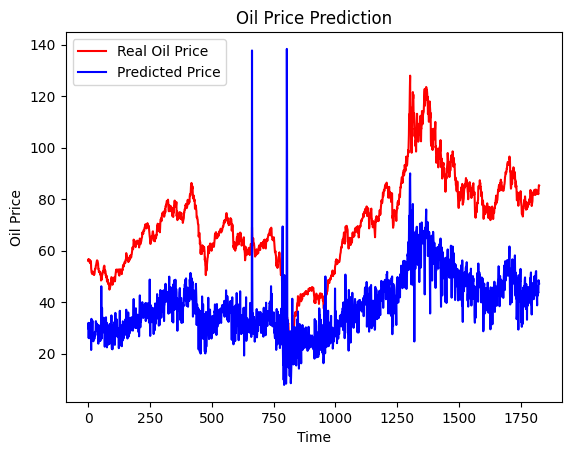

In [31]:
plt.plot(real_price, color='red', label='Real Oil Price')
plt.plot(predictions, color='blue', label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()
plt.show()

In [ ]:
input_data_test = []
for i in range(6):
    feature = float(input(f"Enter value for feature {i+1}: "))
    input_data_test.append(feature)
    
testing_data = pd.Series(input_data_test, index=['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'])

In [ ]:
input_data_test = testing_data.values.reshape(1, -1).repeat(61, axis=0) 
input_data_test_scaled = sc.transform(input_data_test)
predicted_price_test = model.predict(np.array([input_data_test_scaled]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
predicted_price_test = np.array(predicted_price_test).reshape(-1)

In [ ]:
predicted_price_test[0]

29.523085